In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit


# --- 1. Load Data ---
file_path = "1. DeepDeauville Excel complété et anonymisé.xlsx"
df = pd.read_excel(file_path)

# --- 2. Create Deauville_binary Column ---
def classify_deauville(score):
    try:
        s = float(score)
    except:
        return None  # or handle it differently if needed
    if 1 <= s <= 3:
        return "No hypermetabolic lesions"
    elif 4 <= s <= 5:
        return "Hypermetabolic lesions"
    else:
        return None

df["Deauville_binary"] = df["Deauville score "].apply(classify_deauville)

# --- 3. Create AgeGroup Column ---
bins = [0, 30, 45, 60, 75, 120]  # 120 as an upper bound
labels = ['<30', '30-44', '45-59', '60-74', '75+']
df['AgeGroup'] = pd.cut(df['Age Exam'], bins=bins, labels=labels, right=False)

# --- 4. Keep Only Relevant Columns ---
relevant_cols = [
    "PID",
    "Sexe",
    "AgeGroup",              # Use the same name as created above
    "Deauville_binary",
    "Deauville score ",
    "Line of treatment ",
    "Actual problem"
]
df_filtered = df[relevant_cols].copy()


# --- 5. Create a Stratification Label (if using multiple covariates) ---
def make_strat_label(row):
    PID = str(row.get("PID", "Unknown"))
    sexe = str(row.get("Sexe", "Unknown"))
    deauville = str(row.get("Deauville_binary", "Unknown"))

    return f"{sexe}_{deauville}"

# If you want to use the multiple predictors for stratification:
df_filtered['strat_label'] = df_filtered.apply(make_strat_label, axis=1)


In [3]:
#--- 6. Perform Stratified 80/20 Split ---
# Option A: Stratify using the multiple-category strat_label:
train_df, test_df = train_test_split(
    df_filtered, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_filtered['strat_label']
)

# Option B: Alternatively, stratify using the binary outcome:
# train_df, test_df = train_test_split(
#     df_filtered, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=df_filtered['Deauville_binary']
# )

# --- 7. Add a Column Specifying the Split ---
train_df["Split"] = "Train"
test_df["Split"] = "Test"

# --- 8. (Optional) Combine Splits and Save to CSV ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.to_csv("combined_splits.csv", index=False)


In [4]:
# Find the common patient IDs between train and test splits
common_pids = set(train_df['PID']).intersection(set(test_df['PID']))

if common_pids:
    print("There are common patient IDs between train and test splits:")
    print(common_pids)
else:
    print("No common patient IDs found. The splits are patient-wise independent.")


There are common patient IDs between train and test splits:
{401360899, 401408517, 401396741, 401353224, 401399304, 400786937, 401429524, 401371673, 401700897, 401383457, 400722467, 401423398, 401370662, 400799271, 401417258, 406035501, 401350702, 401398831, 401386545, 406151730, 401379381, 401368632, 400826429, 401428546, 401422920, 406143049, 401378378, 401367628, 401421900, 401403473, 401430098, 401415768, 401374298, 400085595, 406138463, 401389157, 401374823, 400214123, 400797806, 401361006, 406003824, 401377397, 401387130, 401388155, 401371772, 401401470, 400128130, 401373826, 401394820, 401356420, 400166025, 401431178, 401372299, 401384588, 406069389, 401384589, 401396369, 401725587, 401397907, 401363607, 401315480, 401416857, 401385627, 401420958, 400210590, 401389729, 401370278, 401414823, 400236720, 401374896, 401368242, 401422520, 401378491, 401354429, 400894654, 401421503, 401418944, 400151233, 401382081, 401308868, 401369293, 401428689, 401315541, 400178907, 401391326, 4017

In [5]:
# Define the columns for which you want to check the distribution
strat_columns = [
    "Sexe",
    "AgeGroup",
    "Deauville_binary",
    "Deauville score ",
    "Line of treatment ",
    "Actual problem"
]

# Loop through each column and print the normalized value counts for train and test sets
for col in strat_columns:
    print(f"Train distribution for {col}:")
    print(train_df[col].value_counts(normalize=True))
    print("\nTest distribution for {col}:")
    print(test_df[col].value_counts(normalize=True))
    print("\n" + "-"*50 + "\n")


Train distribution for Sexe:
Sexe
H    0.594163
F    0.405837
Name: proportion, dtype: float64

Test distribution for {col}:
Sexe
H    0.594444
F    0.405556
Name: proportion, dtype: float64

--------------------------------------------------

Train distribution for AgeGroup:
AgeGroup
60-74    0.274496
45-59    0.250174
30-44    0.210563
75+      0.149409
<30      0.115358
Name: proportion, dtype: float64

Test distribution for {col}:
AgeGroup
60-74    0.313889
45-59    0.219444
30-44    0.200000
<30      0.133333
75+      0.133333
Name: proportion, dtype: float64

--------------------------------------------------

Train distribution for Deauville_binary:
Deauville_binary
No hypermetabolic lesions    0.747741
Hypermetabolic lesions       0.252259
Name: proportion, dtype: float64

Test distribution for {col}:
Deauville_binary
No hypermetabolic lesions    0.747222
Hypermetabolic lesions       0.252778
Name: proportion, dtype: float64

--------------------------------------------------



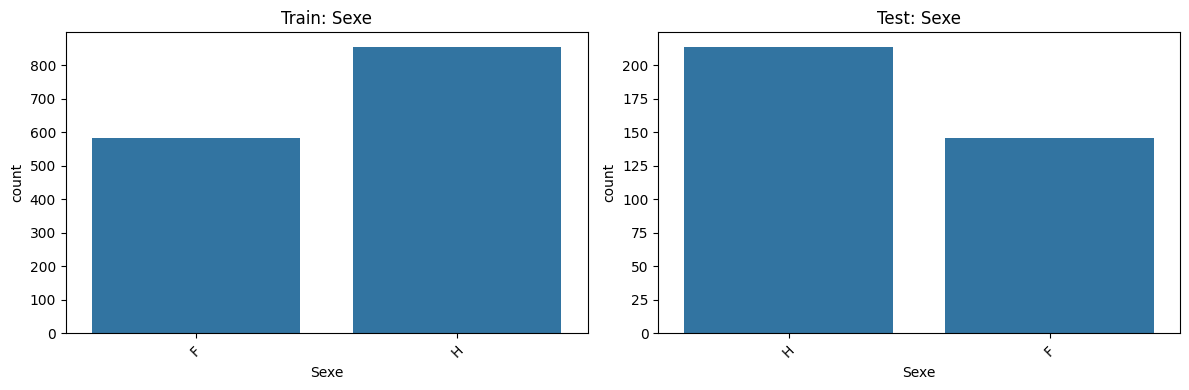

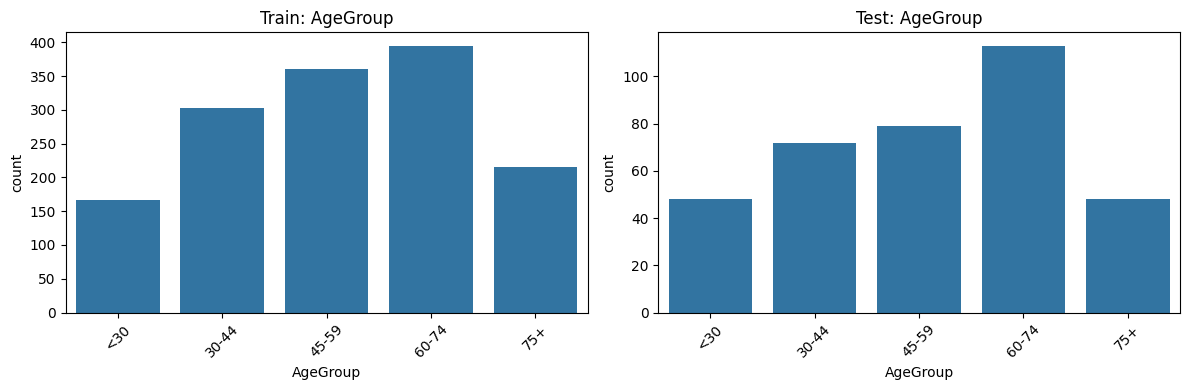

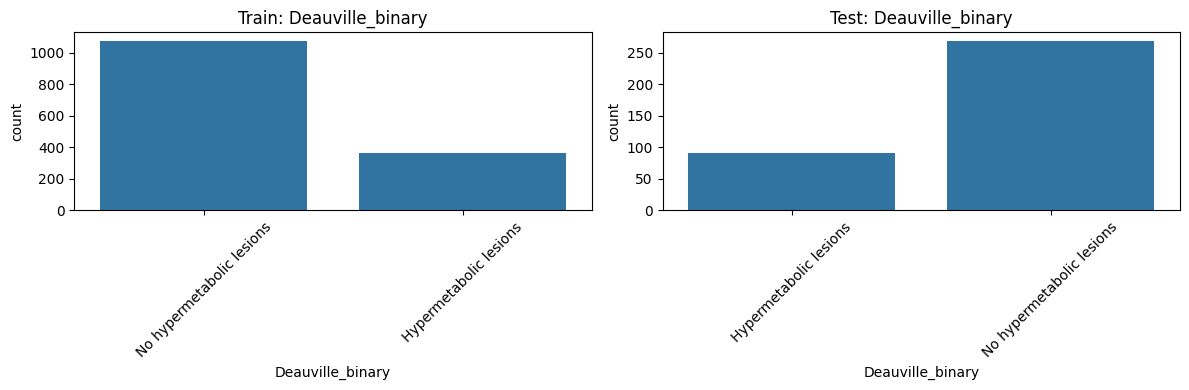

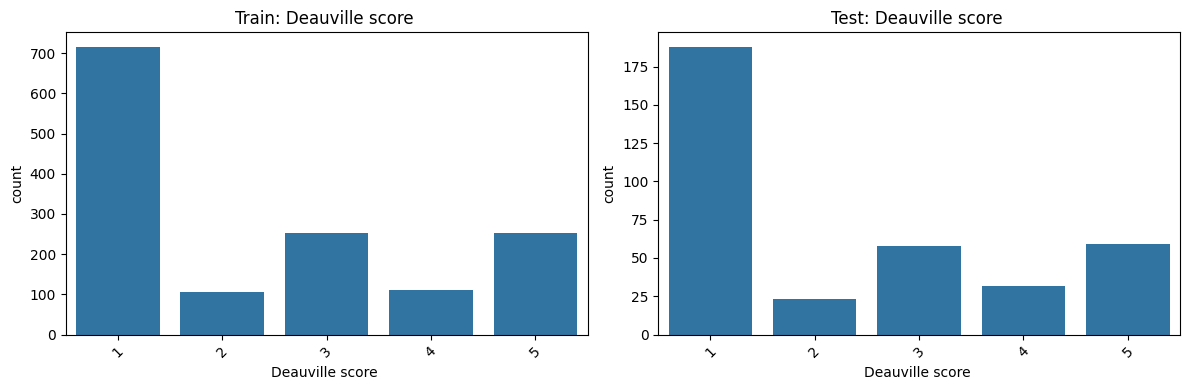

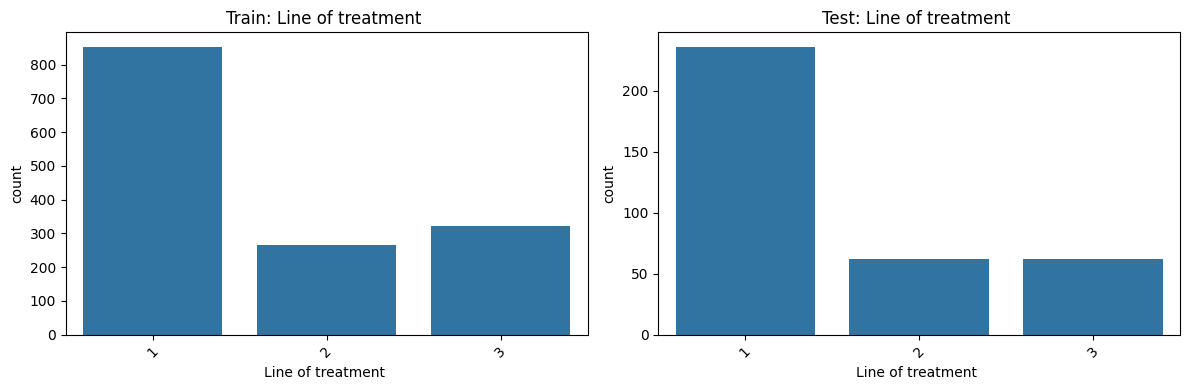

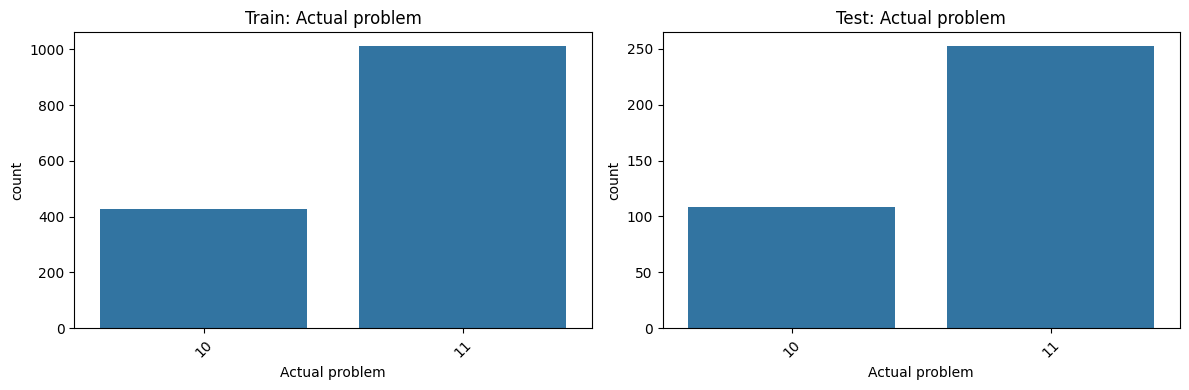

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop over each stratification column to create side-by-side plots
for col in strat_columns:
    plt.figure(figsize=(12, 4))
    
    # Plot for the train set
    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=train_df)
    plt.title(f"Train: {col}")
    plt.xticks(rotation=45)
    
    # Plot for the test set
    plt.subplot(1, 2, 2)
    sns.countplot(x=col, data=test_df)
    plt.title(f"Test: {col}")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


Train distribution for Sexe:
Sexe
H    0.583044
F    0.416956
Name: proportion, dtype: float64

Test distribution for Sexe:
Sexe
H    0.638889
F    0.361111
Name: proportion, dtype: float64

--------------------------------------------------

Train distribution for AgeGroup:
AgeGroup
60-74    0.277276
45-59    0.239055
30-44    0.214732
75+      0.143850
<30      0.125087
Name: proportion, dtype: float64

Test distribution for AgeGroup:
AgeGroup
60-74    0.302778
45-59    0.263889
30-44    0.183333
75+      0.155556
<30      0.094444
Name: proportion, dtype: float64

--------------------------------------------------

Train distribution for Deauville_binary:
Deauville_binary
No hypermetabolic lesions    0.740792
Hypermetabolic lesions       0.259208
Name: proportion, dtype: float64

Test distribution for Deauville_binary:
Deauville_binary
No hypermetabolic lesions    0.775
Hypermetabolic lesions       0.225
Name: proportion, dtype: float64

---------------------------------------------

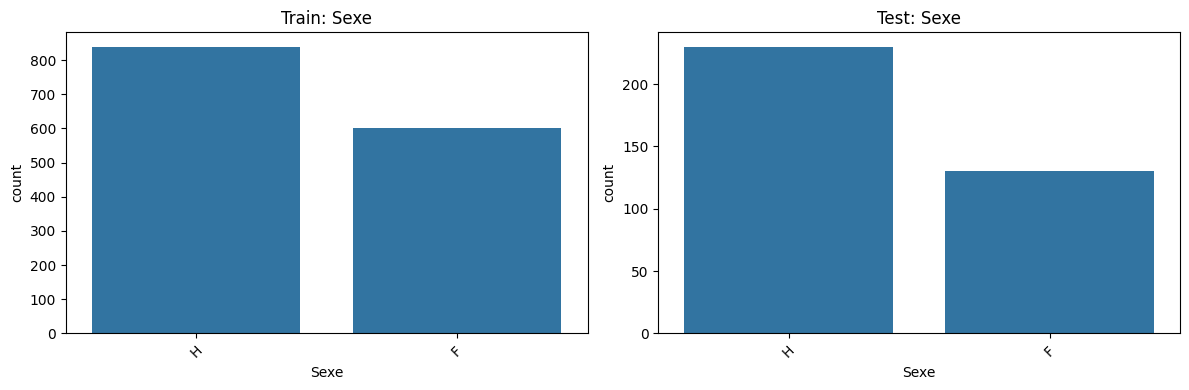

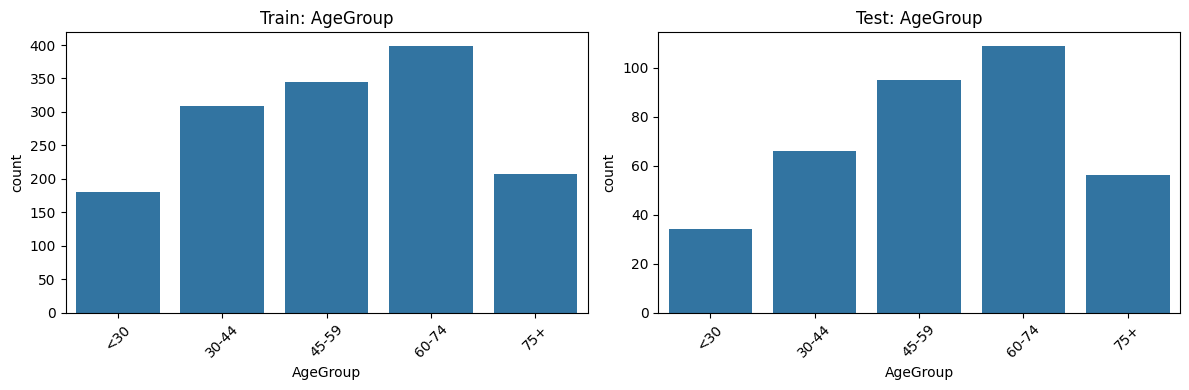

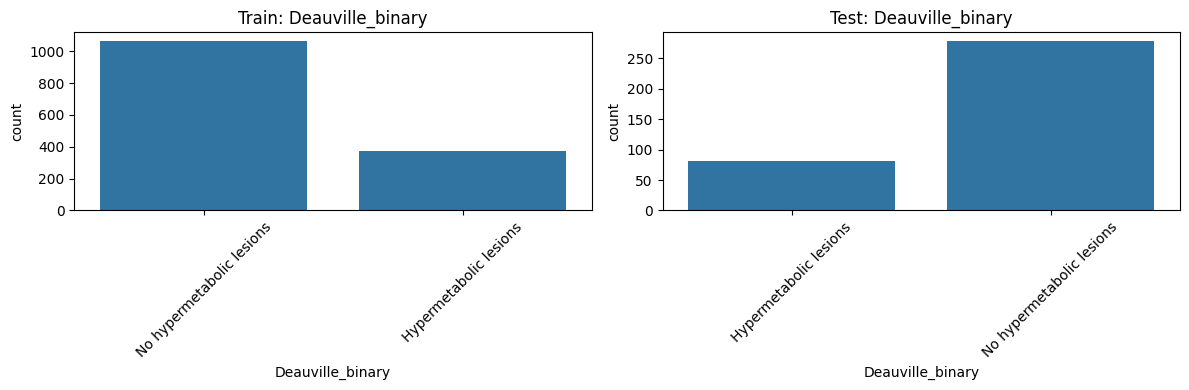

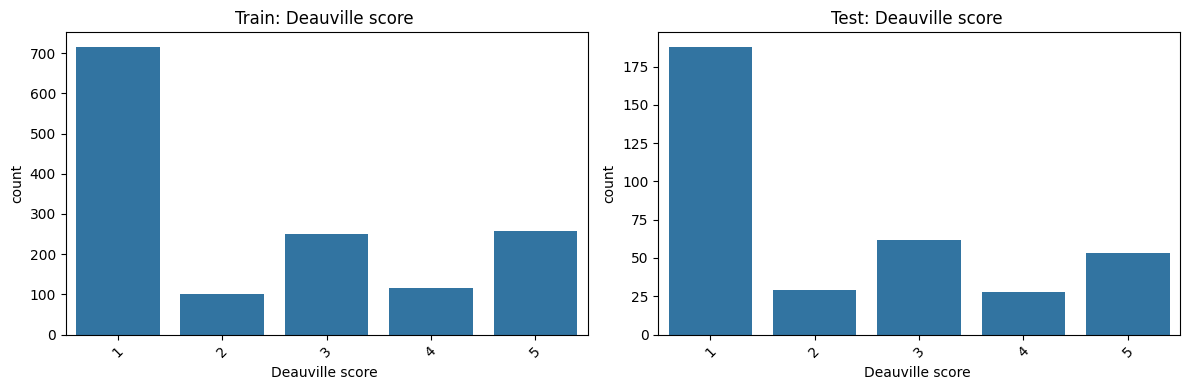

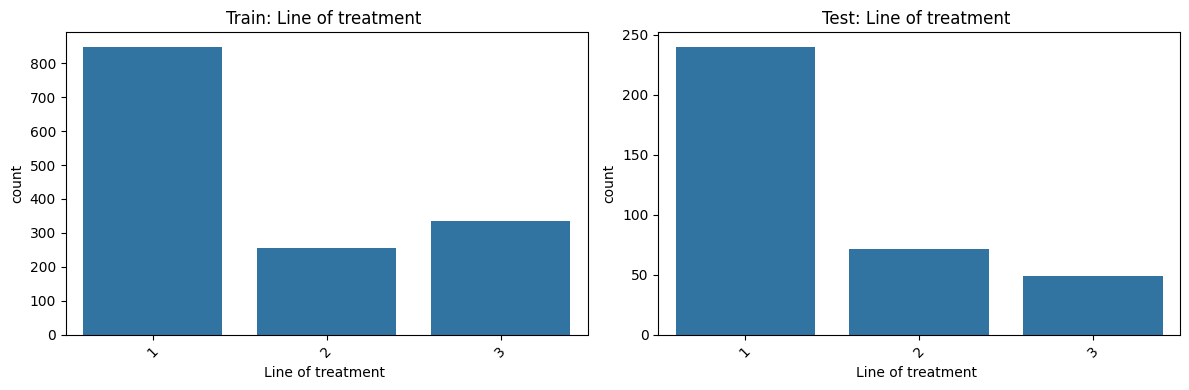

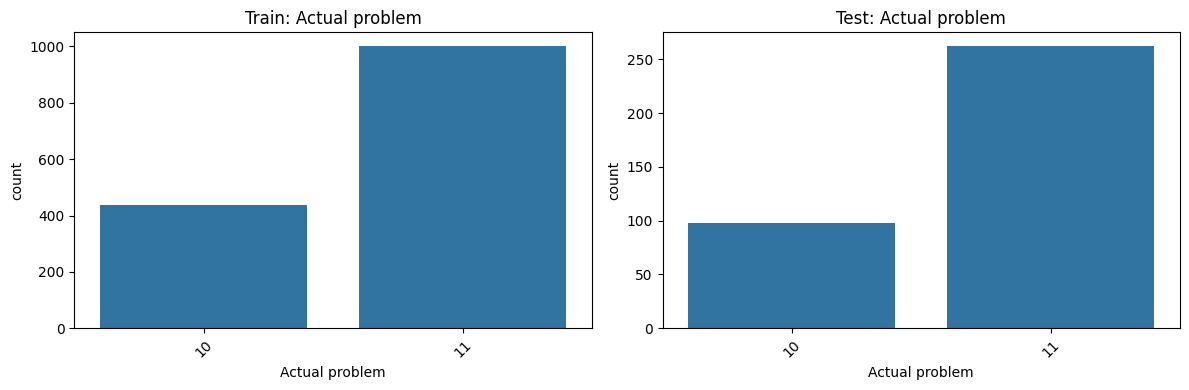

In [ ]:


# --- 6. Perform Patient-Level Split Using GroupShuffleSplit ---
# This guarantees that all records for a given patient (PID) are in the same split.
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
train_idx, test_idx = next(gss.split(df_filtered, groups=df_filtered['PID']))
train_df = df_filtered.iloc[train_idx].copy()
test_df = df_filtered.iloc[test_idx].copy()

# --- 7. Add a Column Specifying the Split ---
train_df["Split"] = "Train"
test_df["Split"] = "Test"

# --- 8. (Optional) Combine Splits and Save to CSV ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.to_csv("combined_splits.csv", index=False)

# --- 9. Check Distribution of Key Variables ---
strat_columns = [
    "Sexe",
    "AgeGroup",
    "Deauville_binary",
    "Deauville score ",
    "Line of treatment ",
    "Actual problem"
]

for col in strat_columns:
    print(f"Train distribution for {col}:")
    print(train_df[col].value_counts(normalize=True))
    print(f"\nTest distribution for {col}:")
    print(test_df[col].value_counts(normalize=True))
    print("\n" + "-"*50 + "\n")

# --- 10. Visualize Distribution with Countplots ---
for col in strat_columns:
    plt.figure(figsize=(12, 4))
    
    # Plot for the train set
    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=train_df)
    plt.title(f"Train: {col}")
    plt.xticks(rotation=45)
    
    # Plot for the test set
    plt.subplot(1, 2, 2)
    sns.countplot(x=col, data=test_df)
    plt.title(f"Test: {col}")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


In [9]:
num_patients = combined_df['PID'].nunique()
print(num_patients)

947
